**INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent the problems while reloading the **Project**. The third line of code helps to make visualization within the notebook. 

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline         

**DOWNLOADING THE DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the **Project** in one particular cell. 

In [44]:
#@ DOWNLOADING THE DEPENDENCIES: UNCOMMENT BELOW:
# !pip install kora -q                                    # Installing the Dependencies for RDKIT.
import kora.install.rdkit                                 # Getting RDKIT. 

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from IPython.display import display

from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA   
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Concatenate
from keras import regularizers
from keras.callbacks import History, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam

**GETTING THE DATA:**
- I have downloaded the dataset from [**REYMOND RESEARCH GROUP**](https://gdb.unibe.ch/downloads/). I will use a file with **SMILES** containing 8 atoms from the GDB11 dataset. And I will do random splitting of the data.

In [4]:
#@ GETTING THE DATA:
PATH = "/content/drive/MyDrive/WORK/gdb11_size08.smi"                           # Path to the Data. 
data = pd.read_csv(PATH, delimiter="\t", names=["smiles", "No", "Int"])         # Reading the Data. 
display(data.head())                                                            # Inspecting the Data
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)   # Splitting the Data. 
display(smiles_train.shape, smiles_test.shape)                                  # Inspecting the shape of Train and Test Data. 

,smiles,No,Int
0,CC(C)CC(C)(C)C,1,1
1,CC(N)CC(C)(C)C,2,1
2,CC(O)CC(C)(C)C,3,1
3,CC(F)CC(C)(C)C,4,1
4,CC(C)(C)CC(F)F,5,1


(50029,)

(16677,)

### **PREPARING THE DATA:**
- I will vectorize the data into one hot arrays.

In [5]:
#@ PREPARING THE DATA:
charset = set("".join(list(data.smiles)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))            # Converting the Characters to Index. 
int_to_char = dict((i, c) for i, c in enumerate(charset))            # Converting the Index to Characters. 
emmbed = max([len(smile) for smile in data.smiles]) + 5              # Maximum length of the SMILES strings. 
print(str(charset))                                                  # Inspecting the Characterset. 
print(len(charset), emmbed)                                          # Inspecting the length of Data. 

{'o', 'H', 'n', 'O', '[', '=', '3', '!', '#', '(', '4', 'c', 'F', 'E', 'N', ']', '2', 'C', '+', '-', '1', ')'}
22 28


- Now the character set and dictionaries are used to set the necessary bits into arrays. 

N#CC#CC1COC1


(50029, 27, 22)

(50029, 27, 22)

(16677, 27, 22)

!N#CC#CC1COC1EEEEEEEEEEEEEE


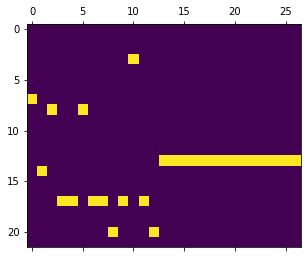

In [6]:
#@ PREPARING THE DATA:
def vectorize(smiles):                                                          # Vectorization.
  one_hot = np.zeros((smiles.shape[0], emmbed, len(charset)), dtype=np.int8)    # Initialization of an empty numpy array.
  for i, smile in enumerate(smiles):
    one_hot[i, 0, char_to_int["!"]] = 1                                         # Encoding the starting character. 
    for j, c in enumerate(smile):
      one_hot[i, j+1, char_to_int[c]] = 1                                       # Encoding the rest of the characters. 
    one_hot[i, len(smile)+1:, char_to_int["E"]] = 1                             # Encoding the ending character. 
  return one_hot[:, 0:-1, :], one_hot[:, 1:, :]
X_train, y_train = vectorize(smiles_train.values)                               # Encoding the Training set. 
X_test, y_test = vectorize(smiles_test.values)                                  # Encoding the Test set. 
print(smiles_train.iloc[0])                                                     # Inspecting the Data.
plt.matshow(X_train[0].T)                                                       # Data Visualization of the arrays. 
display(X_train.shape, y_train.shape, X_test.shape)                             # Inspecting the shape of Data. 
print("".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])) # Converting the Index into Characters. 

### **LONG SHORT TERM MEMORY:**
- **LSTM** is a special kind of **Neural Netoworks** that are designed to keep an internal states for longer iterations through a **Recurrent Neural Networks**. They have input, output and forget gates. 

In [7]:
#@ LONG SHORT TERM MEMORY:
input_shape = X_train.shape[1:]                                           # Shape of input.
output_dim = y_train.shape[-1]                                            # Shape of output. 
latent_dim = 64
lstm_dim = 64
#@ ENCODER:
unroll = False
encoder_inputs = Input(shape=input_shape)                                 # Inputs of the Encoder. 
encoder = LSTM(lstm_dim, return_state=True, unroll=unroll)                # Encoder using LSTM. 
encoder_outputs, state_h, state_c = encoder(encoder_inputs)               
states = Concatenate(axis=-1)([state_h, state_c])                         # Concatenation of two states. 
neck = Dense(latent_dim, activation="relu")                               # Implementation of RELU.
neck_outputs = neck(states)
#@ DECODER:
decode_h = Dense(lstm_dim, activation="relu")                             # Implementation of Decoder. 
decode_c = Dense(lstm_dim, activation="relu")                             # Implementation of Decoder. 
state_h_decoded = decode_h(neck_outputs)                                  # Decoder.
state_c_decoded = decode_c(neck_outputs)                                  # Decoder.
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs =  Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll)          # Implementation of LSTM.
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation="softmax")                      # Output Layer.
decoder_outputs = decoder_dense(decoder_outputs)                             # Implemenatation of Decoders. 
#@ DEFINING THE MODEL:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)             # Instantiating the Model. 
display(model.summary())                                                     # Inspecting the summary of the Model. 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27, 22)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  22272       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128)          0           lstm[0][1]                       
                                                                 lstm[0][2]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        concatenate[0][0]            

None

**PREPARING THE MODEL:**
- I will create the **Keras** callbacks to record the history and reduce the learning rate once the **Training** stops progressing. The model is compiled with optimizer and loss function. 

In [8]:
history = History()                                                    # Instantiating the History Module. 
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10,
                        min_lr=0.000001, verbose=1, min_delta=1e-5)    # Instantiating the Module for Learning Rate. 
optimizer = Adam(lr=0.005)                                             # Initializing the Adam Optimizer. 
model.compile(optimizer=optimizer, loss="categorical_crossentropy")    # Compiling the Model.
model.fit([X_train, X_train], y_train, epochs=200,                     # Using the Training Data. 
          batch_size=256, shuffle=True, callbacks=[history, rlr],      # Implementation of Callbacks. 
          validation_data=([X_test, X_test], y_test))                  # Training the Model.        

Epoch 1/200
196/196 [==============================] - 11s 13ms/step - loss: 1.1965 - val_loss: 0.6557
Epoch 2/200
196/196 [==============================] - 2s 8ms/step - loss: 0.6289 - val_loss: 0.5704
Epoch 3/200
196/196 [==============================] - 2s 8ms/step - loss: 0.5855 - val_loss: 0.5430
Epoch 4/200
196/196 [==============================] - 2s 8ms/step - loss: 0.5378 - val_loss: 0.5002
Epoch 5/200
196/196 [==============================] - 2s 8ms/step - loss: 0.4928 - val_loss: 0.4639
Epoch 6/200
196/196 [==============================] - 2s 8ms/step - loss: 0.4634 - val_loss: 0.4453
Epoch 7/200
196/196 [==============================] - 2s 8ms/step - loss: 0.4398 - val_loss: 0.4219
Epoch 8/200
196/196 [==============================] - 2s 8ms/step - loss: 0.4224 - val_loss: 0.4012
Epoch 9/200
196/196 [==============================] - 2s 8ms/step - loss: 0.3830 - val_loss: 0.3519
Epoch 10/200
196/196 [==============================] - 2s 8ms/step - loss: 0.3611 - val_

**SAVING THE MODEL:**
- I will save the best model recorded in the **History** object. 

In [9]:
#@ SAVING THE MODEL:
import pickle
filename = "Firstmodel.pickle"                        # Name of the file. 
pickle.dump(history.history, open(filename, "wb"))    # Saving the Model. 

**PLOTTING THE TRAINING PROCESS:**

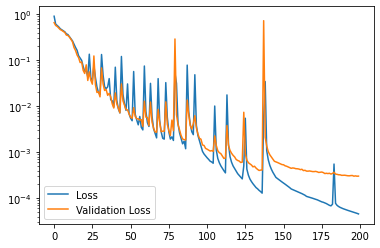

In [10]:
#@ PLOTTING THE TRAINING PROCESS:
plt.plot(history.history["loss"], label="Loss")                # Plotting the Loss.
plt.plot(history.history["val_loss"], label="Validation Loss") # Plotting the Validation Loss. 
plt.yscale("log")
plt.legend()
plt.show()                                                     # Plotting the Training Process. 

- A quick test directly on the **Model** shows that there is a good reconstruction accuracy on the test set. 

In [11]:
#@ 100 TESTED SMILES:
for i in range(100):
  value = model.predict([X_test[i:i+1], X_test[i:i+1]])
  idxs = np.argmax(value, axis=2)                                        # Flattened along the axis.
  pred = "".join([int_to_char[x] for x in idxs[0]])[:-1]
  idxs2 = np.argmax(X_test[i:i+1], axis=2)                               # Flattened along the axis. 
  true = "".join([int_to_char[h] for h in idxs2[0]])[1:]
  if true != pred:
    print(true, pred)                                                    # Inspecting the result. 

**PREPARING THE MODEL**
- The parts of the trained autoencoder will be used to build the various encoder and decoder models. This **MODEL** will take a vectorized smile and encode it to the latent space. 

In [12]:
#@ PREPARING THE MODEL:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)              # Building the Model.
smiles_to_latent_model.save("SecondModel.h5")                             # Saving the Model.

**PREPARING THE MODEL**
- The next model which is needed is a **MODEL** that can decode the latent space into the states that need to be set at the decoder **LSTM** cells. 

In [13]:
#@ PREPARING THE MODEL:
latent_input = Input(shape=(latent_dim, ))                                            # Latent Input. 
state_h_decoded_2 = decode_h(latent_input)                                            # Reusing the Layers. 
state_c_decoded_2 = decode_c(latent_input)                                            # Reusing the Layers. 
latent_to_states_model = Model(latent_input, [state_h_decoded_2, state_c_decoded_2])  # Building the Model. 
latent_to_states_model.save("ThirdModel.h5")                                          # Saving the Model. 

### **PREPARING THE DECODER MODEL:**
- The **DECODER MODEL** needs to be changed. It was trained on batch mode but it should be used in stateful mode predicting one character at a time. So a batch shape and **LSTM** layer is set to be stateful.  

In [14]:
#@ PREPARING THE DECODER MODEL:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))                    # Decoder Inputs. 
inf_decoder_lstm = LSTM(lstm_dim, return_sequences=True, unroll=unroll,
                        stateful=True)                                            # Stateful Decoder LSTM.
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)                        # Decoder Outputs. 
inf_decoder_dense = Dense(output_dim, activation="softmax")                       # Output of the Model.
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
model_s = Model(inf_decoder_inputs, inf_decoder_outputs)                          # Stateful Decoder Model. 
#@ TRANSFERRING WEIGHTS:
for i in range(1, 3):
  model_s.layers[i].set_weights(model.layers[i+6].get_weights())                  # Transferring the Weights. 
model_s.save("StatefulModel.h5")                                                  # Saving the Model.
display(model_s.summary())                                                        # Inspecting the Summary of the Model.

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(1, 1, 22)]              0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 64)                22272     
_________________________________________________________________
dense_4 (Dense)              (1, 1, 22)                1430      
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


None

- The **Smiles to Latent Model** is used to encode the smiles into the latent space. 

In [40]:
#@ LATENT SPACE:
x_latent = smiles_to_latent_model.predict(X_test)                             # Encoding into Latent Space. 
molno = 5
latent_mol = smiles_to_latent_model.predict(X_test[molno:molno+1])
sort_l = np.argsort(np.sum(np.abs(x_latent - latent_mol), axis=1))            # Sorting the result.
print(sort_l[:10])                                                            # Inspecting the sorted result.
print(smiles_test.iloc[sort_l[0:8]])

[    5  1243 15472 14589 15039  3991  5251   744  2449  7197]
45051    COCc1cocn1
45007    COCc1ccoc1
45061    COCc1conn1
44719    COCc1ccno1
45069    COCc1ncon1
44727    COCc1cnno1
44751    COCc1ncno1
45025    CCOc1cnoc1
Name: smiles, dtype: object


**CHEMICAL PROERTIES:**

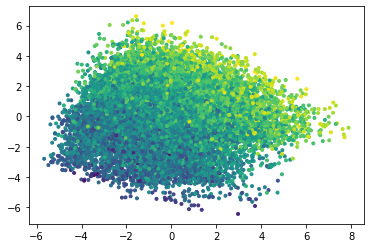

[0.1763033  0.14416036] 0.32046366


In [42]:
#@ CHEMICAL PROPERTIES:
logp = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP) 
pca = PCA(n_components=2)                                                   # Instantiating the PCA.
pca_r = pca.fit_transform(x_latent)
plt.figure()
plt.scatter(pca_r[:, 0], pca_r[:, 1], marker=".", c=logp)                   # Plotting the Scatter Plot. 
plt.show()                                                                  # Plotting the result. 
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_)) # Inspecting the result. 

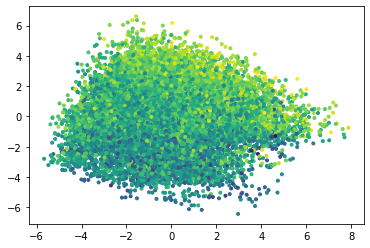

In [43]:
#@ CHEMICAL PROPERTIES:
mol_wt = smiles_test.apply(Chem.MolFromSmiles).apply(Descriptors.MolMR)
plt.figure()
plt.scatter(pca_r[:, 0], pca_r[:, 1], marker=".", c=mol_wt)                  # Plotting the Scatter Plot. 
plt.show()                                                                   # Plotting the Scatter Plot. 

- By inspecting the result obtained above it can be concluded that there seems to have some distribution of predicted molecular properties. 

**MODELING PROPERTIES FOR LATENT SPACE:**


In [48]:
#@ LATENT SPACE MODEL:
x_train_latent = smiles_to_latent_model.predict(X_train)                        # Encoding the Smiles to Latent Space.
logp_train = smiles_train.apply(Chem.MolFromSmiles).apply(Descriptors.MolLogP)
logp_model = Sequential()                                                       # Initailizing the Sequential Model. 
logp_model.add(Dense(128, input_shape=(latent_dim, ), activation="relu"))       # Adding the first Dense Layer.
logp_model.add(Dense(128, activation="relu"))                                   # Adding the second Dense Layer. 
logp_model.add(Dense(1))                                                        # Output Dense Layer.
#@ COMPILING AND TRAINING THE MODEL:
logp_model.compile(optimizer="adam", loss="mse")                                # Compiling the Model. 
rlr = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=10,
                        min_lr=0.000001, verbose=1, min_delta=1e-5)             # Initializing the Callbacks.
logp_model.fit(x_train_latent, logp_train, batch_size=128, epochs=400, 
               callbacks=[rlr])                                                 # Training the Model. 

Epoch 1/400
391/391 [==============================] - 1s 2ms/step - loss: 0.3518
Epoch 2/400
391/391 [==============================] - 1s 2ms/step - loss: 0.2067
Epoch 3/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1751
Epoch 4/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1585
Epoch 5/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1451
Epoch 6/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1387
Epoch 7/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1334
Epoch 8/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1284
Epoch 9/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1236
Epoch 10/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1216
Epoch 11/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1179
Epoch 12/400
391/391 [==============================] - 1s 2ms/step - loss: 0.1158
Epoch 13/400


**PLOTTING THE TRAINING PROCESS:**

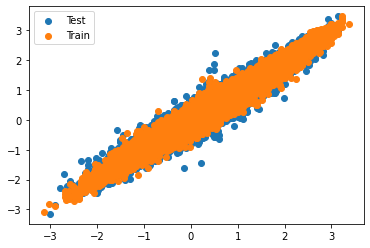

In [49]:
#@ PLOTTING THE TRAINING PROCESS:
logp_pred_train = logp_model.predict(x_train_latent)
logp_pred_test = logp_model.predict(x_latent)
plt.scatter(logp, logp_pred_test, label="Test")                           # Plotting the Scatter Plot. 
plt.scatter(logp_train, logp_pred_train, label="Train")                   # Plotting the Scatter Plot.
plt.legend()
plt.show()                                                                # Data Visualization.

**LATENT SPACE TO SMILES:**
- To compute the latent space I will compute the states using **Latent to States Model** and set the initial states of the decoder **LSTM** network. 

In [50]:
#@ LATENT SPACE TO SMILES:
def latent_to_smiles(latent):
  states = latent_to_states_model.predict(latent)                           # Decoding the States.
  model_s.layers[1].reset_states(states=[states[0], states[1]])             # Resetting the States of LSTM.
  startidx = char_to_int["!"]
  samplevec = np.zeros((1, 1, 22))                                          # Initializing the arrays of zeros.
  samplevec[0, 0, startidx] = 1                                             # Encoding.
  smiles = ""
  for i in range(28):
    o = model_s.predict(samplevec)
    sampleidx = np.argmax(o)
    samplechar = int_to_char[sampleidx]                                     # Converting the Integers to Characters. 
    if samplechar != "E":
      smiles = smiles + int_to_char[sampleidx]
      samplevec = np.zeros((1, 1, 22))
      samplevec[0, 0, sampleidx] = 1
    else:
      break
  return smiles
#@ LATENT SPACE TO SMILES:
smiles = latent_to_smiles(x_latent[0:1])                                    # Invoking the Function.
print(smiles, smiles_test.iloc[0])                                          # Inspecting the Result.

NCCC1OC=NO1 NCCC1OC=NO1


- I will inspect the fraction of the **SMILES** which are malformed when sampling the test set. 

In [51]:
#@ INSPECTING THE SMILES:
wrong = 0
for i in range(1000):
  smiles = latent_to_smiles(x_latent[i:i+1])                                      # Converting the Latent to Smiles. 
  mol = Chem.MolFromSmiles(smiles)
  if mol:
    pass
  else:
    print(smiles)
    wrong += 1
print("%0.1F percent smiles are wrong formatted" % (wrong / float(1000)*100))     # Inspecting the result. 

0.0 percent smiles are wrong formatted


**INTERPOLATION TEST IN LATENT SPACE:**

RDKit ERROR: [08:23:52] Explicit valence for atom # 7 F, 2, is greater than permitted


OCC1C=NNCF1


RDKit ERROR: [08:23:53] Explicit valence for atom # 7 F, 2, is greater than permitted


OCC1C=NNCF1


RDKit ERROR: [08:23:54] Explicit valence for atom # 7 O, 3, is greater than permitted


OCC1C=NNC=O1


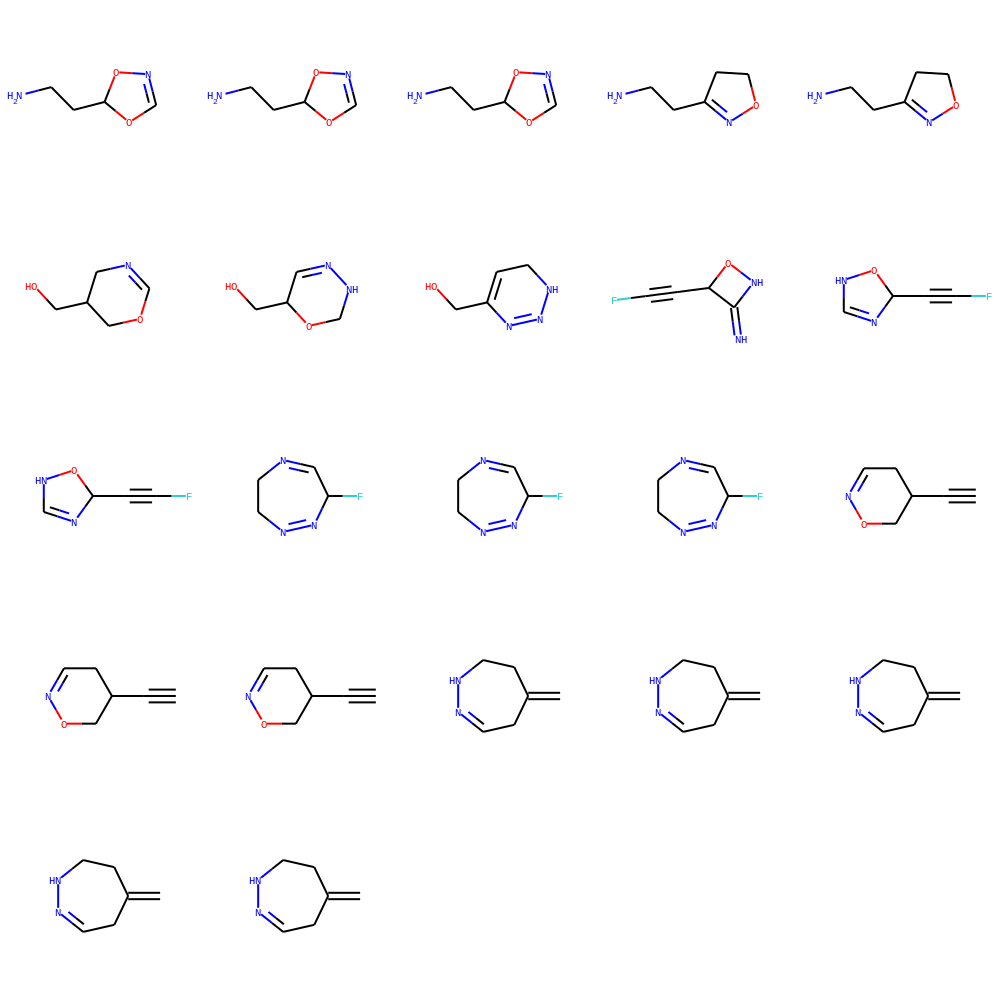

In [52]:
#@ INTERPOLATION TEST IN LATENT SPACE:
i = 0
j = 2
latent1 = x_latent[j:j+1]
latent0 = x_latent[i:i+1]
mols1 = []
ratios = np.linspace(0, 1, 25)
for r in ratios:
  rlatent = (1.0 - r) * latent0 + r*latent1
  smiles = latent_to_smiles(rlatent)                         # Converting the Latent Space to Smiles. 
  mol = Chem.MolFromSmiles(smiles)
  if mol:
    mols1.append(mol)
  else:
    print(smiles)
Draw.MolsToGridImage(mols1, molsPerRow=5)                    # Data Visualization. 

**SAMPLE AROUND THE LATENT VECTOR:**

RDKit ERROR: [08:32:03] SMILES Parse Error: ring closure 1 duplicates bond between atom 5 and atom 7 for input: 'NCCCOC1(O)O1'


NCCCOC1(O)O1


RDKit ERROR: [08:32:05] SMILES Parse Error: duplicated ring closure 1 bonds atom 4 to itself for input: 'ONCCC11CN=O'


ONCCC11CN=O


RDKit ERROR: [08:32:05] Explicit valence for atom # 5 O, 3, is greater than permitted


NCCC1CO=C1O


RDKit ERROR: [08:32:06] Explicit valence for atom # 7 O, 3, is greater than permitted


NCCC1ONC=O1


RDKit ERROR: [08:32:08] Explicit valence for atom # 4 O, 3, is greater than permitted


NCCC1O(CO)O1


RDKit ERROR: [08:32:10] Explicit valence for atom # 4 O, 3, is greater than permitted


NCCC1O(O)CO1
NCCC1OCO1N


RDKit ERROR: [08:32:10] Explicit valence for atom # 6 O, 3, is greater than permitted


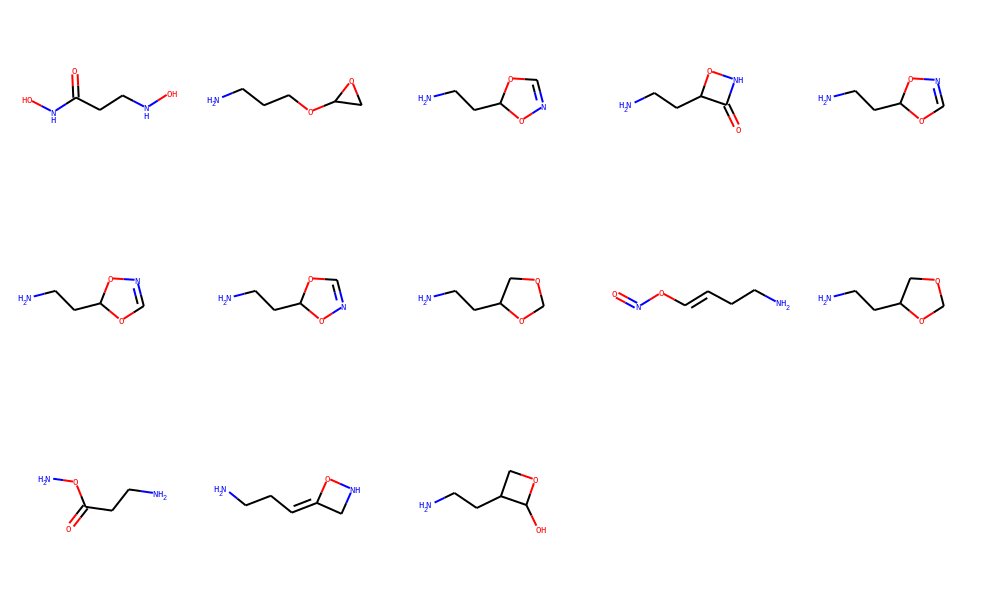

In [53]:
#@ SAMPLE AROUND THE LATENT VECTOR:
latent = x_latent[0:1]
scale = 0.40
mols = []
for i in range(20):
  latent_r = latent + scale*(np.random.randn(latent.shape[1]))
  smiles = latent_to_smiles(latent_r)                             # Converting Latent Space to Smiles. 
  mol = Chem.MolFromSmiles(smiles)
  if mol:
    mols.append(mol)                                              # Appending to the empty list. 
  else:
    print(smiles)
Draw.MolsToGridImage(mols, molsPerRow=5)                          # Data Visualization. 

- Here is the **LSTM** based autoencoders of **SMILES** of molecules and trained with **Teacher Enforcing**. 